# POS tagging using modified Viterbi

### Data Preparation

In [34]:
#Importing libraries
import nltk
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
import time
import gc
from collections import Counter
import re
from sklearn.metrics import confusion_matrix

#### Please skip the block below if the universal tagset is already available

In [36]:
#Downloading the universal tagset
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Niraj\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [37]:
# reading the Treebank sentences with tags from the universal tagset
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [38]:
# viewing the first three tagged sentences
print(nltk_data[:2])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]


In [39]:
# Converting the list of sentences into a list of words

tagged_words_corpus = [tagged_word for sentence in nltk_data for tagged_word in sentence]
print(len(tagged_words_corpus))
tagged_words_corpus[:5]

100676


[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN')]

In [40]:
#Converting the words to lower case
tagged_words = [tagged_word[0].lower() for tagged_word in tagged_words_corpus]

#Creating a list of tags as they'll need to be zipped with the words to regenerate the corpus
tags_for_words = [tagged_word[1] for tagged_word in tagged_words_corpus]

#Checking if the number of words and tags is the same (to verify that all words have tags)
print(len(tagged_words))
print(len(tags_for_words))

100676
100676


In [41]:
#Zipping the words and their corresponding tags back together
tagged_words_corpus = list(zip(tagged_words, tags_for_words))

#Viewing the length of the corpus and the first five word-tag pairs in the corpus
print(len(tagged_words_corpus))
tagged_words_corpus[:5]

100676


[('pierre', 'NOUN'),
 ('vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN')]

In [42]:
# Splitting into training and validation sets and checking the first 10 pairs in the train set

train_set, validation_set = train_test_split(tagged_words_corpus, test_size=0.05, random_state = 100)
print(len(train_set))
print(len(validation_set))
print(train_set[:10])

95642
5034
[('``', '.'), ('tool', 'NOUN'), ('is', 'VERB'), ('for', 'ADP'), ('and', 'CONJ'), ('future', 'ADJ'), ('to', 'PRT'), ('surfaced', 'VERB'), ('$', '.'), ('this', 'DET')]


In [43]:
#Deleting variables that we don't need and triggering garbage collection

del tagged_words, tags_for_words
gc.collect()

50

In [44]:
# Creating a vocabulary to check the number of unique words in the train set

words = [pair[0] for pair in train_set]
Vocab = list(set(words))
print(len(Vocab))

11062


In [47]:
# number of tags
T = set([pair[1] for pair in train_set])
POS_tags = list(T)

#Sorting the POS tags so that the same tag is at the start of the transition probabilities matrix
POS_tags = sorted(POS_tags)
print(len(T))
print(len(POS_tags))

12
12


In [48]:
#Taking a look at the tags in the universal tagset
print(POS_tags)

['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


In [49]:
#Deleting variables that we don't need and triggering garbage collection

del words
gc.collect()

120

## Vanilla Viterbi based POS tagger

### Emission Probabilities

In [50]:
# Creating a matrix of zeros to store the p(w/t) values
t = len(POS_tags)
v = len(Vocab)
w_given_t = np.zeros((t, v))

In [51]:
w_given_t.shape

(12, 11062)

In [52]:
type(train_set)

list

In [53]:
#Function to calculate the number of instances of a word with a given tag 

def word_given_tag(word, tag):
    tag_list = [pair for pair in train_set if pair[1]==tag]
    count_tag = len(tag_list)
    word_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_word_given_tag = len(word_given_tag_list)
    
    return (count_word_given_tag, count_tag)

In [58]:
print(word_given_tag('ran', 'NOUN'))
print(word_given_tag('ran', 'VERB'))
print(word_given_tag('ran', 'ADJ'))

(0, 27481)
(5, 12894)
(0, 6076)


### Transition Probabilities

In [55]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1):
    tags = [pair[1] for pair in train_set]
    count_t1 = len([t for t in tags if t == t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if (tags[index] == t1) and (tags[index+1] == t2):
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [57]:
#Checking which  tags precede the noun and verb tags
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('VERB', 'ADV'))
print(t2_given_t1('NOUN', 'CONJ'))
print(t2_given_t1('VERB', 'PRON'))
print(t2_given_t1('NOUN', 'ADP'))

(1731, 6076)
(390, 3008)
(589, 2154)
(325, 2593)
(2668, 9345)


The output of this function can be interpreted in this way: the tag 'ADJ' appears 6076 times in the training set. In 1731 of these 6076 occurrences, the tag 'NOUN' follows the tag 'ADJ'.

In [59]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(POS_tags), len(POS_tags)), dtype='float32')
for i, t1 in enumerate(list(POS_tags)):
    for j, t2 in enumerate(list(POS_tags)):
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [60]:
print(tags_matrix.shape)

(12, 12)


In [61]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(POS_tags), index=list(POS_tags))

In [62]:
print(tags_df.shape)
tags_df.head()

(12, 12)


,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0.117366,0.059719,0.098000,0.032697,0.020177,0.087732,0.285804,0.035129,0.027563,0.031706,0.135201,0.068907
ADJ,0.117676,0.062870,0.094305,0.031764,0.023864,0.085912,0.284891,0.034727,0.028802,0.030941,0.136109,0.068137
ADP,0.111825,0.066239,0.098555,0.031033,0.021830,0.083039,0.285500,0.035634,0.028143,0.033815,0.141894,0.062386
ADV,0.111702,0.063830,0.102061,0.028258,0.027261,0.082447,0.301529,0.036237,0.024269,0.028590,0.129654,0.064162
CONJ,0.121170,0.059424,0.100743,0.029248,0.018570,0.096100,0.273445,0.032033,0.025070,0.028319,0.149025,0.066852


In [63]:
#Checking the probability of different POS tags after a period tag
tags_df.loc['.', :]

.       0.117366
ADJ     0.059719
ADP     0.098000
ADV     0.032697
CONJ    0.020177
DET     0.087732
NOUN    0.285804
NUM     0.035129
PRON    0.027563
PRT     0.031706
VERB    0.135201
X       0.068907
Name: ., dtype: float32

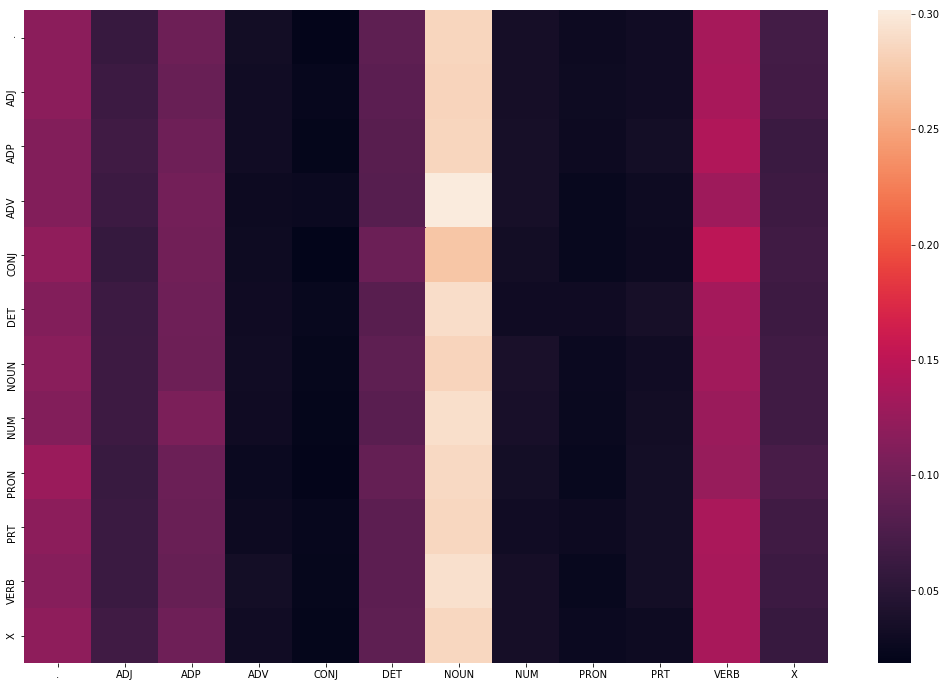

In [64]:
# heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

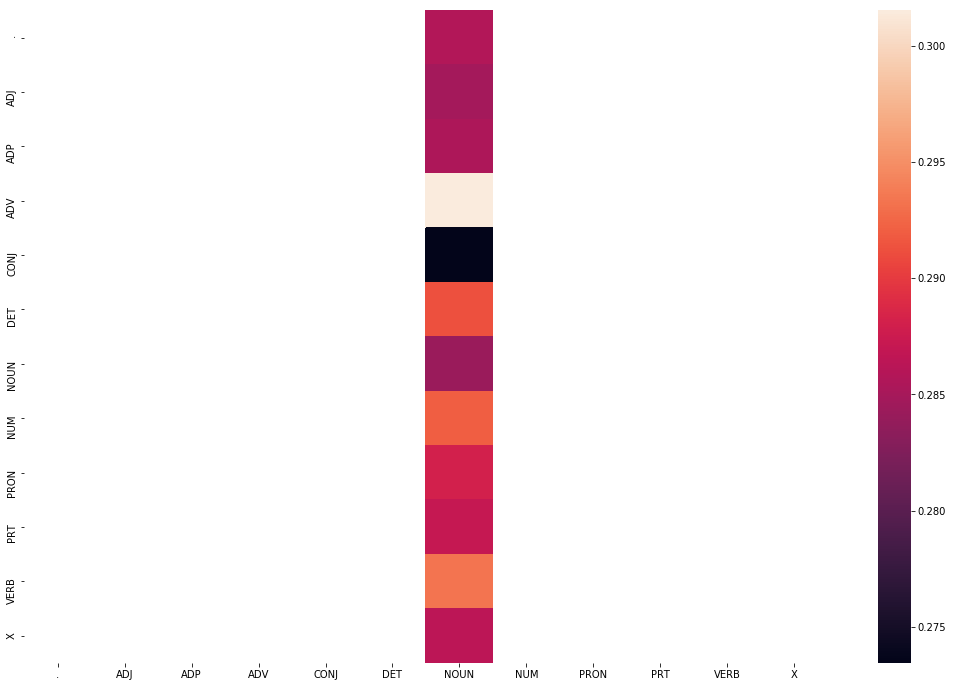

In [65]:
# frequent tags
# filter the df to get P(t2, t1) > 0.15
tags_frequent = tags_df[tags_df>0.15]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

#### The second heat map shows that the transition probability is highest for nouns. This means that for any given t1, the (transition) probability of getting 'NOUN' as t2 is higher than the probability of getting any other POS tag as t2.

In [66]:
#Triggering garbage collection
gc.collect()

8486

#### Writing a function that follows the vanilla viterbi heuristic

In [67]:
# Viterbi Heuristic
def Viterbi(words):
    #initialising a list to store the tag with the max state probability for each word
    tags_list = []
    
    for key, word in enumerate(words):
        
        #initialising a list to calculate state probability for all tags for each word
        prob_list = []
        
        for tag in POS_tags:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[tags_list[-1], tag]
            
            # calculating the emission probability for the current word and tag
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # computing the state probability for the current word and tag
            state_probability = emission_p * transition_p    
            
            # appending state probability to list of state probabilities for current word and tag
            prob_list.append(state_probability)
        
        # finding the max state probability for this word
        prob_max = max(prob_list)
        
        # getting the tag with the max state probability for this word
        tag_with_max_state_prob = POS_tags[prob_list.index(prob_max)] 
        tags_list.append(tag_with_max_state_prob)
        
    return list(zip(words, tags_list))


#### Preparing the validation set to check the performance of the algorithm

In [68]:
# Creating a list of tagged words in the validation set
validation_words = [tagged_word[0] for tagged_word in validation_set]
len(validation_words)

5034

In [69]:
# Creating a list of POS tags in the validation set
validation_tags = [tagged_word[1] for tagged_word in validation_set]
len(validation_tags)

5034

## Model Building

### 1. Using the vanilla Viterbi algorithm to tag the words in the validation set and check the performance of the algorithm

In [70]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(validation_words)
end = time.time()
difference = end-start

In [71]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  1564.2469232082367
[('61', 'NUM'), ('noodles', '.'), ('tokyo', 'NOUN'), ('the', 'DET'), ('buy', 'VERB'), ('beginning', 'VERB'), ('of', 'ADP'), ('circulation', 'NOUN'), ('bill', 'NOUN'), ('account', 'NOUN'), ('of', 'ADP'), ('``', '.'), ('a', 'DET'), ('*-2', 'X'), ('persuasive', '.'), ('*', 'X'), ('traders', 'NOUN'), ('over', 'ADP'), ('a', 'DET'), ('a', 'DET'), ('*-1', 'X'), ('there', 'DET'), ('miami', 'NOUN'), (',', '.'), ('hefty', 'ADJ'), ("'s", 'PRT'), ('be', 'VERB'), ('noting', 'VERB'), ('1990', 'NUM'), ('stores', 'NOUN'), ('of', 'ADP'), ('*t*-133', '.'), ('estimated', 'VERB'), ('company', 'NOUN'), ('of', 'ADP'), ('talks', 'NOUN'), ('4.6', 'NUM'), ('japanese', 'ADJ'), ('due', 'ADJ'), ('*rnr*-1', 'X'), ('comment', 'NOUN'), ('a.l.', '.'), ('of', 'ADP'), (',', '.'), ('.', '.'), ('the', 'DET'), ('concern', 'NOUN'), ('of', 'ADP'), ('they', 'PRON'), ('of', 'ADP'), ('reached', 'VERB'), ('april', 'NOUN'), ('helped', 'VERB'), ('exact', 'ADJ'), ('form', 'NOUN'), ('his',

In [72]:
# creating a list of word-tag pairs that have been tagged correctly 

correctly_tagged_pairs = [i for i, j in zip(tagged_seq, zip(validation_words, validation_tags)) if i == j] 

In [73]:
#Checking the percentage of words that were tagged correctly

accuracy = len(correctly_tagged_pairs)/len(tagged_seq)
accuracy

0.8969010727056019

#### Let's take a look at the words that have been tagged incorrectly

In [77]:
# creating a list of word-tag pairs that have been tagged incorrectly 

incorrectly_tagged_pairs = [i for i, j in zip(tagged_seq, zip(validation_words, validation_tags)) if i != j] 

In [80]:
# Checking which tag appears most frequently in the list of incorrectly tagged words

Counter([i[1] for i in incorrectly_tagged_pairs]).most_common(3)

[('.', 331), ('NOUN', 62), ('ADJ', 47)]

#### '.' is the tag that appears most frequently in the list of incorrectly tagged words. This is because, '.' is the first tag in the POS tags list, and the vanilla viterbi algorithm assigns this tag for unknown words

In [81]:
#Triggering garbage collection
gc.collect()

1238

### Solving the problem of unknown words

### 2. Using the most commonly occurring tag in the train set

Since '.' is the most commonly occurring tag in the list of incorrectly tagged words, let's insert the most commonly occurring tag in the train set for unknown words.

In [85]:
#Creating a list of tags in the train set
tags_in_train_set = [pair[1] for pair in train_set]

#Using the Counter() class to count how many times each tag appears in the train set
tag_counts = Counter(tags_in_train_set)

#Finding the most common POS tag in the train set
most_common_tag = tag_counts.most_common(1)[0][0]

#Comparing the number of tags in the train set and the number of occurrences of the most common tag
print(tag_counts.most_common(1))
print(len(tags_in_train_set))
print(most_common_tag)

[('NOUN', 27481)]
95642
NOUN


In [86]:
# Using the Viterbi heuristic and assigning the most common tag for words that are not present in the train set

def Viterbi_2(words):
    #initialising a list to store the tag with the max state probability for each word
    tags_list = []
    
    for key, word in enumerate(words):
        
        if word in Vocab:
        
            #initialising a list to calculate state probability for all tags for each word
            prob_list = []

            for tag in POS_tags:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[tags_list[-1], tag]

                # calculating the emission probability for the current word and tag
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                
                # computing the state probability for the current word and tag
                state_probability = emission_p * transition_p    

                # appending state probability to list of state probabilities for current word and tag
                prob_list.append(state_probability)

            # finding the max state probability for this word
            prob_max = max(prob_list)
            
            # getting the tag with the max state probability for this word
            tag_with_max_state_prob = POS_tags[prob_list.index(prob_max)] 
            tags_list.append(tag_with_max_state_prob)
        
        else:
            tags_list.append(most_common_tag)
        
    return list(zip(words, tags_list))

#### Using this modified alogrithm to tag the words in the validation set

In [87]:
# tagging the test sentences
start_2 = time.time()
tagged_seq_2 = Viterbi_2(validation_words)
end_2 = time.time()
difference_2 = end_2 - start_2

In [88]:
print("Time taken in seconds: ", difference_2)
print(tagged_seq_2)

Time taken in seconds:  1474.4693160057068
[('61', 'NUM'), ('noodles', 'NOUN'), ('tokyo', 'NOUN'), ('the', 'DET'), ('buy', 'VERB'), ('beginning', 'VERB'), ('of', 'ADP'), ('circulation', 'NOUN'), ('bill', 'NOUN'), ('account', 'NOUN'), ('of', 'ADP'), ('``', '.'), ('a', 'DET'), ('*-2', 'X'), ('persuasive', 'NOUN'), ('*', 'X'), ('traders', 'NOUN'), ('over', 'ADP'), ('a', 'DET'), ('a', 'DET'), ('*-1', 'X'), ('there', 'DET'), ('miami', 'NOUN'), (',', '.'), ('hefty', 'ADJ'), ("'s", 'PRT'), ('be', 'VERB'), ('noting', 'VERB'), ('1990', 'NUM'), ('stores', 'NOUN'), ('of', 'ADP'), ('*t*-133', 'NOUN'), ('estimated', 'VERB'), ('company', 'NOUN'), ('of', 'ADP'), ('talks', 'NOUN'), ('4.6', 'NUM'), ('japanese', 'ADJ'), ('due', 'ADJ'), ('*rnr*-1', 'X'), ('comment', 'NOUN'), ('a.l.', 'NOUN'), ('of', 'ADP'), (',', '.'), ('.', '.'), ('the', 'DET'), ('concern', 'NOUN'), ('of', 'ADP'), ('they', 'PRON'), ('of', 'ADP'), ('reached', 'VERB'), ('april', 'NOUN'), ('helped', 'VERB'), ('exact', 'ADJ'), ('form', 'NOU

In [89]:
# creating a list of word-tag pairs that have been tagged correctly 

correctly_tagged_pairs_2 = [i for i, j in zip(tagged_seq_2, zip(validation_words, validation_tags)) if i == j]

In [90]:
#Checking the percentage of words that were tagged correctly

accuracy_2 = len(correctly_tagged_pairs_2)/len(tagged_seq_2)
accuracy_2

0.9259038537941995

In [91]:
#Triggering garbage collection
gc.collect()

43

### 3. Dealing with unknown words by creating rules based on the morphology of the word 

In [92]:
# Using the Viterbi heuristic and using rules for words that are not present in the train set

def Viterbi_3(words):
    #initialising a list to store the tag with the max state probability for each word
    tags_list = []
    
    for key, word in enumerate(words):
        
        if word in Vocab:
        
            #initialising a list to calculate state probability for all tags for each word
            prob_list = []

            for tag in POS_tags:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[tags_list[-1], tag]

                # calculating the emission probability for the current word and tag
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                
                # computing the state probability for the current word and tag
                state_probability = emission_p * transition_p    

                # appending state probability to list of state probabilities for current word and tag
                prob_list.append(state_probability)

            # finding the max state probability for this word
            prob_max = max(prob_list)
            
            # getting the tag with the max state probability for this word
            tag_with_max_state_prob = POS_tags[prob_list.index(prob_max)] 
            tags_list.append(tag_with_max_state_prob)
        
        else:
            #function call
            morph_tag = morphology_rules([word])
            tags_list.append(morph_tag)
        
    return list(zip(words, tags_list))

#### Checking the words that were incorrectly tagged by the vanilla viterbi algorithm to identify the kind of rules required

In [93]:
incorrectly_tagged_pairs = [i for i, j in zip(tagged_seq, zip(validation_words, validation_tags)) if i != j]
incorrectly_tagged_pairs

[('noodles', '.'),
 ('persuasive', '.'),
 ('*t*-133', '.'),
 ('a.l.', '.'),
 ('3648.82', '.'),
 ("'s", 'PRT'),
 ('evaluated', '.'),
 ('altruistic', '.'),
 ('10.5', '.'),
 ('portrayed', '.'),
 ('inside', '.'),
 ('offering', 'NOUN'),
 ('*t*-93', '.'),
 ('even', 'ADV'),
 ('*t*-161', '.'),
 ('planes', '.'),
 ('eveready', '.'),
 ('acted', '.'),
 ('disregard', '.'),
 ('up', 'PRT'),
 ('referrals', '.'),
 ('watchdogs', '.'),
 ('then-speaker', '.'),
 ('up', 'PRT'),
 ('tell', '.'),
 ('sue', '.'),
 ('schoolchildren', '.'),
 ('christmas', '.'),
 ('initiating', '.'),
 ('8.48', '.'),
 ('exit', '.'),
 ('50-50', '.'),
 ('fifteen', '.'),
 ('*t*-165', '.'),
 ('decrease', 'VERB'),
 ('match', 'NOUN'),
 ('international', 'NOUN'),
 ('contradictions', '.'),
 ('developments', '.'),
 ('hit', 'VERB'),
 ('reading', 'NOUN'),
 ('in', 'ADP'),
 ('barely', '.'),
 ('new', 'ADJ'),
 ('east', 'NOUN'),
 ('tunes', '.'),
 ('*-150', '.'),
 ('much', 'ADJ'),
 ('in', 'ADP'),
 ('near-limit', '.'),
 ('lungs', '.'),
 ('outsiders',

#### Creating a list of patterns that can be used with RegexpTagger

In [94]:
# specifying patterns for tagging

patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'VERB'),             # modals
    (r'.*ize$', 'VERB'),              # verb
    (r'.*ise$', 'VERB'),              # verb
    (r'.*ous$', 'ADJ'),               # adjectives
    (r'.*able$', 'ADJ'),              # adjectives
    (r'.*less$', 'ADJ'),              # adjectives
    (r'.*al$', 'ADJ'),                # adjectives
    (r'.*ful$', 'ADJ'),               # adjectives
    (r'.*ory$', 'ADJ'),               # adjectives
    (r'.*tic$', 'ADJ'),               # adjectives
    (r'.*ly$', 'ADV'),                # adverbs
    (r'.*ness$', 'NOUN'),             # nouns
    (r'.*ion$', 'NOUN'),              # nouns
    (r'.*or$', 'NOUN'),               # nouns
    (r'.*ty$', 'NOUN'),               # nouns
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'[0-9]*\.?[0-9]+$', 'NUM'),     # cardinal numbers
    (r'[a-z]+-[a-z]+', 'ADJ'),        # hyphenated words - adjectives
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN')                   # nouns
]

In [95]:
#Creating a function that checks for pattern matches

def morphology_rules(word):
    regexp_tagger = nltk.RegexpTagger(patterns)
    pair = regexp_tagger.tag(word)
    return pair[0][1]


#### Using this modified alogrithm to tag the words in the validation set

In [96]:
# tagging the test sentences
start_3 = time.time()
tagged_seq_3 = Viterbi_3(validation_words)
end_3 = time.time()
difference_3 = end_3 - start_3

In [97]:
print("Time taken in seconds: ", difference_3)
print(tagged_seq_3)

Time taken in seconds:  1441.5843422412872
[('61', 'NUM'), ('noodles', 'VERB'), ('tokyo', 'NOUN'), ('the', 'DET'), ('buy', 'VERB'), ('beginning', 'VERB'), ('of', 'ADP'), ('circulation', 'NOUN'), ('bill', 'NOUN'), ('account', 'NOUN'), ('of', 'ADP'), ('``', '.'), ('a', 'DET'), ('*-2', 'X'), ('persuasive', 'NOUN'), ('*', 'X'), ('traders', 'NOUN'), ('over', 'ADP'), ('a', 'DET'), ('a', 'DET'), ('*-1', 'X'), ('there', 'DET'), ('miami', 'NOUN'), (',', '.'), ('hefty', 'ADJ'), ("'s", 'PRT'), ('be', 'VERB'), ('noting', 'VERB'), ('1990', 'NUM'), ('stores', 'NOUN'), ('of', 'ADP'), ('*t*-133', 'NOUN'), ('estimated', 'VERB'), ('company', 'NOUN'), ('of', 'ADP'), ('talks', 'NOUN'), ('4.6', 'NUM'), ('japanese', 'ADJ'), ('due', 'ADJ'), ('*rnr*-1', 'X'), ('comment', 'NOUN'), ('a.l.', 'NOUN'), ('of', 'ADP'), (',', '.'), ('.', '.'), ('the', 'DET'), ('concern', 'NOUN'), ('of', 'ADP'), ('they', 'PRON'), ('of', 'ADP'), ('reached', 'VERB'), ('april', 'NOUN'), ('helped', 'VERB'), ('exact', 'ADJ'), ('form', 'NOU

In [98]:
# creating a list of word-tag pairs that have been tagged correctly 

correctly_tagged_pairs_3 = [i for i, j in zip(tagged_seq_3, zip(validation_words, validation_tags)) if i == j]

In [99]:
#Checking the percentage of words that were tagged correctly

accuracy_3 = len(correctly_tagged_pairs_3)/len(tagged_seq_3)
accuracy_3

0.9429876837504966

In [100]:
#Triggering garbage collection
gc.collect()

80

### 4. Dealing with unknown words by considering only the transition probabilities for unknown words

In [101]:
# Using the Viterbi heuristic and ignoring the emission probability for words that are not in the train set

def Viterbi_4(words):
    #initialising a list to store the tag with the max state probability for each word
    tags_list = []
    
    for key, word in enumerate(words):
        
        #initialising a list to calculate state probability for all tags for each word
        prob_list = []

        for tag in POS_tags:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[tags_list[-1], tag]

            # checking if the current word exists in the vocabulary
            if (word in Vocab):
                # calculating the emission probability and state probabiliy for the current word and tag
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p
            else:
                # setting the transition probability as state probability since the emission prob will be zero for a word
                # that's not in the vocabulary
                state_probability = transition_p
            
            # appending state probability to list of state probabilities for current word and tag
            prob_list.append(state_probability)

        # finding the max state probability for this word
        prob_max = max(prob_list)

        # getting the tag with the max state probability for this word
        tag_with_max_state_prob = POS_tags[prob_list.index(prob_max)]
        tags_list.append(tag_with_max_state_prob)
        
    return list(zip(words, tags_list))

#### Using this modified alogrithm to tag the words in the validation set

In [102]:
# tagging the test sentences
start_4 = time.time()
tagged_seq_4 = Viterbi_4(validation_words)
end_4 = time.time()
difference_4 = end_4 - start_4

In [103]:
print("Time taken in seconds: ", difference_4)
print(tagged_seq_4)

Time taken in seconds:  1466.207983493805
[('61', 'NUM'), ('noodles', 'NOUN'), ('tokyo', 'NOUN'), ('the', 'DET'), ('buy', 'VERB'), ('beginning', 'VERB'), ('of', 'ADP'), ('circulation', 'NOUN'), ('bill', 'NOUN'), ('account', 'NOUN'), ('of', 'ADP'), ('``', '.'), ('a', 'DET'), ('*-2', 'X'), ('persuasive', 'NOUN'), ('*', 'X'), ('traders', 'NOUN'), ('over', 'ADP'), ('a', 'DET'), ('a', 'DET'), ('*-1', 'X'), ('there', 'DET'), ('miami', 'NOUN'), (',', '.'), ('hefty', 'ADJ'), ("'s", 'PRT'), ('be', 'VERB'), ('noting', 'VERB'), ('1990', 'NUM'), ('stores', 'NOUN'), ('of', 'ADP'), ('*t*-133', 'NOUN'), ('estimated', 'VERB'), ('company', 'NOUN'), ('of', 'ADP'), ('talks', 'NOUN'), ('4.6', 'NUM'), ('japanese', 'ADJ'), ('due', 'ADJ'), ('*rnr*-1', 'X'), ('comment', 'NOUN'), ('a.l.', 'NOUN'), ('of', 'ADP'), (',', '.'), ('.', '.'), ('the', 'DET'), ('concern', 'NOUN'), ('of', 'ADP'), ('they', 'PRON'), ('of', 'ADP'), ('reached', 'VERB'), ('april', 'NOUN'), ('helped', 'VERB'), ('exact', 'ADJ'), ('form', 'NOUN

In [104]:
# creating a list of word-tag pairs that have been tagged correctly 

correctly_tagged_pairs_4 = [i for i, j in zip(tagged_seq_4, zip(validation_words, validation_tags)) if i == j]

In [105]:
#Checking the percentage of words that were tagged correctly

accuracy_4 = len(correctly_tagged_pairs_4)/len(tagged_seq_4)
accuracy_4

0.9259038537941995

In [106]:
#Triggering garbage collection
gc.collect()

40

### 5. Using Laplace smoothing

In [107]:
# Using the Viterbi heuristic with Laplace smoothing 

def Viterbi_5(words):
    #initialising a list to store the tag with the max state probability for each word
    tags_list = []
    
    #Initializing alpha value for laplace smoothing
    alpha = 0.01
    
    for key, word in enumerate(words):
        
        #initialising a list to calculate state probability for all tags for each word
        prob_list = []

        for tag in POS_tags:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[tags_list[-1], tag]
           
            # calculating the emission probability and state probabiliy for the current word and tag
            emission_p = (word_given_tag(words[key], tag)[0] + alpha)/(word_given_tag(words[key], tag)[1] 
                                                                        + (alpha*len(POS_tags)))
            state_probability = emission_p * transition_p

            # appending state probability to list of state probabilities for current word and tag
            prob_list.append(state_probability)

        # finding the max state probability for this word
        prob_max = max(prob_list)

        # getting the tag with the max state probability for this word
        tag_with_max_state_prob = POS_tags[prob_list.index(prob_max)]
        tags_list.append(tag_with_max_state_prob)
        
    return list(zip(words, tags_list))

#### Using this modified alogrithm to tag the words in the validation set

In [108]:
# tagging the test sentences
start_5 = time.time()
tagged_seq_5 = Viterbi_5(validation_words)
end_5 = time.time()
difference_5 = end_5 - start_5

In [109]:
print("Time taken in seconds: ", difference_5)
print(tagged_seq_5)

Time taken in seconds:  2045.8845884799957
[('61', 'NUM'), ('noodles', 'ADP'), ('tokyo', 'NOUN'), ('the', 'DET'), ('buy', 'VERB'), ('beginning', 'VERB'), ('of', 'ADP'), ('circulation', 'NOUN'), ('bill', 'NOUN'), ('account', 'NOUN'), ('of', 'ADP'), ('``', '.'), ('a', 'DET'), ('*-2', 'X'), ('persuasive', 'ADJ'), ('*', 'X'), ('traders', 'NOUN'), ('over', 'ADP'), ('a', 'DET'), ('a', 'DET'), ('*-1', 'X'), ('there', 'DET'), ('miami', 'NOUN'), (',', '.'), ('hefty', 'ADJ'), ("'s", 'PRT'), ('be', 'VERB'), ('noting', 'VERB'), ('1990', 'NUM'), ('stores', 'NOUN'), ('of', 'ADP'), ('*t*-133', 'PRT'), ('estimated', 'VERB'), ('company', 'NOUN'), ('of', 'ADP'), ('talks', 'NOUN'), ('4.6', 'NUM'), ('japanese', 'ADJ'), ('due', 'ADJ'), ('*rnr*-1', 'X'), ('comment', 'NOUN'), ('a.l.', 'NUM'), ('of', 'ADP'), (',', '.'), ('.', '.'), ('the', 'DET'), ('concern', 'NOUN'), ('of', 'ADP'), ('they', 'PRON'), ('of', 'ADP'), ('reached', 'VERB'), ('april', 'NOUN'), ('helped', 'VERB'), ('exact', 'ADJ'), ('form', 'NOUN'),

In [110]:
# creating a list of word-tag pairs that have been tagged correctly 

correctly_tagged_pairs_5 = [i for i, j in zip(tagged_seq_5, zip(validation_words, validation_tags)) if i == j]

In [111]:
#Checking the percentage of words that were tagged correctly

accuracy_5 = len(correctly_tagged_pairs_5)/len(tagged_seq_5)
accuracy_5

0.9006754072308304

In [112]:
#Triggering garbage collection
gc.collect()

80

## Evaluating tagging accuracy

#### Comparing the tagging accuracies of the modifications with the vanilla Viterbi algorithm

We've seen the tagging accuracies of all the variations of the Viterbi algorithm. Let's put them together to compare them.

In [124]:
print("Accuracy of various models:")
print("Vanilla Viterbi algorithm: {}".format(round(accuracy*100, 2)))
print("Modified Viterbi tagger that inserts the most common tag for unknown words: {}".format(round(accuracy_2*100, 2)))
print("Modified Viterbi tagger that uses rule-based tagging for unknown words: {}".format(round(accuracy_3*100, 2)))
print("Modified Viterbi tagger that uses only the transition probabilities for unknown words: {}".format(round(accuracy_4*100, 2)))
print("Modified Viterbi tagger that uses Laplace smoothing: {}".format(round(accuracy_5*100, 2)))

Accuracy of various models:
Vanilla Viterbi algorithm: 89.69
Modified Viterbi tagger that inserts the most common tag for unknown words: 92.59
Modified Viterbi tagger that uses rule-based tagging for unknown words: 94.3
Modified Viterbi tagger that uses only the transition probabilities for unknown words: 92.59
Modified Viterbi tagger that uses Laplace smoothing: 90.07


#### The third model, the rule-based tagger, has the highest accuracy percentage. Note that the second and fourth models have the same accuracy percentage. We'll discuss this below. 

#### Next, let's compare the confusion matrices of the five models to make sure that the accuracies are not due to correct tagging of one or two types of tags. The performance should be spread across different types of tags.

### Model 1

In [113]:
conf_matrix_viterbi = pd.DataFrame(confusion_matrix([i[1] for i in tagged_seq], validation_tags, labels = POS_tags), columns=POS_tags, index=POS_tags)
conf_matrix_viterbi

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,612,49,0,13,0,0,147,38,0,0,63,21
ADJ,0,246,2,9,0,0,33,0,0,0,3,0
ADP,0,0,501,10,0,14,0,0,0,4,1,0
ADV,0,2,4,126,0,0,0,0,0,3,1,0
CONJ,0,0,1,0,111,0,0,0,0,0,0,0
DET,0,0,0,2,0,418,3,0,0,0,0,0
NOUN,0,21,0,1,0,1,1185,0,0,0,39,0
NUM,0,0,0,0,0,0,1,146,2,0,0,0
PRON,0,0,0,0,0,0,1,0,142,0,0,0
PRT,1,0,4,2,0,0,0,0,0,157,4,0


#### Rows represent true labels and columns represent prediced labels. This confusion matrix shows that a lot of words get tagged as '.' This is because, this is the first POS tag in the transition probabilities matrix. Note that the performance seems to be fairly even: a lot of different tags are being correctly identified.

### Model 2

In [114]:
conf_matrix_viterbi_2 = pd.DataFrame(confusion_matrix([i[1] for i in tagged_seq_2], validation_tags, labels = POS_tags), columns=POS_tags, index=POS_tags)
conf_matrix_viterbi_2

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,612,0,0,0,0,0,0,0,0,0,0,0
ADJ,0,246,2,9,0,0,33,0,0,0,3,0
ADP,0,0,501,10,0,14,0,0,0,4,1,0
ADV,0,2,4,126,0,0,0,0,0,3,1,0
CONJ,0,0,1,0,111,0,0,0,0,0,0,0
DET,0,0,0,2,0,418,3,0,0,0,0,0
NOUN,0,70,0,14,0,1,1332,38,0,0,103,21
NUM,0,0,0,0,0,0,1,146,2,0,0,0
PRON,0,0,0,0,0,0,1,0,142,0,0,0
PRT,1,0,4,2,0,0,0,0,0,157,4,0


#### In this model, the number of words that are tagged as NOUN increases as we're tagging all unknown words as NOUN.

### Model 3

In [115]:
conf_matrix_viterbi_3 = pd.DataFrame(confusion_matrix([i[1] for i in tagged_seq_3], validation_tags, labels = POS_tags), columns=POS_tags, index=POS_tags)
conf_matrix_viterbi_3

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,612,0,0,0,0,0,0,0,0,0,0,0
ADJ,0,268,2,9,0,0,41,0,0,0,3,0
ADP,0,0,501,10,0,14,0,0,0,4,1,0
ADV,0,3,4,138,0,0,1,0,0,3,1,0
CONJ,0,0,1,0,111,0,0,0,0,0,0,0
DET,0,0,0,2,0,418,3,0,0,0,0,0
NOUN,0,37,0,2,0,1,1310,6,0,0,61,21
NUM,0,0,0,0,0,0,1,178,2,0,0,0
PRON,0,0,0,0,0,0,1,0,142,0,0,0
PRT,1,0,4,2,0,0,0,0,0,157,4,0


#### In this model, the number of words that are correctly tagged as ADJ and VERB increases when compared to the previous model. This is because a lot of rules identify words that are adjectives and verbs.

### Model 4

In [116]:
conf_matrix_viterbi_4 = pd.DataFrame(confusion_matrix([i[1] for i in tagged_seq_4], validation_tags, labels = POS_tags), columns=POS_tags, index=POS_tags)
conf_matrix_viterbi_4

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,612,0,0,0,0,0,0,0,0,0,0,0
ADJ,0,246,2,9,0,0,33,0,0,0,3,0
ADP,0,0,501,10,0,14,0,0,0,4,1,0
ADV,0,2,4,126,0,0,0,0,0,3,1,0
CONJ,0,0,1,0,111,0,0,0,0,0,0,0
DET,0,0,0,2,0,418,3,0,0,0,0,0
NOUN,0,70,0,14,0,1,1332,38,0,0,103,21
NUM,0,0,0,0,0,0,1,146,2,0,0,0
PRON,0,0,0,0,0,0,1,0,142,0,0,0
PRT,1,0,4,2,0,0,0,0,0,157,4,0


#### This model produces the same results as the first modified Viterbi model. That's because for all given t1, t2 is highest for nouns (as we saw in the second heatmap). Therefore, all unknown words are tagged as NOUNs by this model too.

### Model 5

In [117]:
conf_matrix_viterbi_5 = pd.DataFrame(confusion_matrix([i[1] for i in tagged_seq_5], validation_tags, labels = POS_tags), columns=POS_tags, index=POS_tags)
conf_matrix_viterbi_5

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,612,0,0,0,0,0,7,2,0,0,3,1
ADJ,0,250,2,9,0,0,46,3,0,0,8,1
ADP,0,2,501,10,0,14,6,2,0,4,5,1
ADV,0,5,4,129,0,0,17,6,0,3,7,4
CONJ,0,4,1,1,111,0,17,2,0,0,2,0
DET,0,1,0,2,0,418,5,1,0,0,1,3
NOUN,0,21,0,1,0,1,1185,0,0,0,39,0
NUM,0,12,0,4,0,0,32,156,2,0,19,2
PRON,0,2,0,0,0,0,6,1,142,0,4,1
PRT,1,9,4,4,0,0,28,7,0,157,18,6


#### This model doesn't perform as well as the other models. It's performance can be improved by tuning the alpha value that's used for Laplace smoothing. However, since that's very resource intensive and we have other models that are performing well, I'm retaining this alpha value.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

As we can see, the rule-based tagger performs best. Let's compare the performance of the vanilla Viterbi tagger and the rule-based modified Viterbi tagger.

In [220]:
#Entering each sentence as a string
test_sentences = ["Android is a mobile operating system developed by Google.", 
                  "Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
                  "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
                  'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
                  'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
                  'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
                  'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
                  'Show me the cheapest round trips from Dallas to Atlanta.',
                  'I would like to see flights from Denver to Philadelphia.',
                  'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
                  'NASA invited social media users to experience the launch of ICESAT-2 Satellite.']


In [221]:
#Checking the number of test sentences
len(test_sentences)

11

In [222]:
#Joining all the sentences with a space to make a test set that is one string object

test_set = ' '.join([sent for sent in test_sentences])
test_set

"Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta. I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite."

In [223]:
#Checking the length of the test set and its type
print(len(test_set))
print(type(test_set))

994
<class 'str'>


In [224]:
#Splitting the string on spaces to get individual words as items in a list
test_words = test_set.split(' ')
test_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 "Twitter's",
 'firehose.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets.',
 'Before',
 'entering',
 'politics,',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup,',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years.',
 'This',
 'is',
 'the',
 'first',
 'World',

In [225]:
#Splitting '.' as separate characters as '.' has its own part of speech tag

test_words = [[word[:-1], word[-1]] if '.' in word else word for word in test_words]
test_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 ['Google', '.'],
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 ['2013', '.'],
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 "Twitter's",
 ['firehose', '.'],
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 ['tweets', '.'],
 'Before',
 'entering',
 'politics,',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 ['personality', '.'],
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup,',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 ['years', '.'],
 'This'

In [226]:
#Flattening the list

flat_test_words  = []
for sublist in test_words:
    if type(sublist) is list:
        for word in sublist:
            flat_test_words.append(word)
    else:
        flat_test_words.append(sublist)
        
flat_test_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 "Twitter's",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics,',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup,',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.',
 'This',
 'is

In [ ]:
flat_test_words = [word.lower() for word in flat_test_words]

In [227]:
#Checking the number of test words in the flat list
len(flat_test_words)

179

In [228]:
#Using the vanilla viterbi tagger and the rule-based viterbi tagger to tag the test words

test_Viterbi_vanilla = Viterbi(flat_test_words)
test_Viterbi_rule = Viterbi_3(flat_test_words)

In [229]:
#Zipping the two lists to compare the performance of the two taggers

list(zip(test_Viterbi_vanilla, test_Viterbi_rule))

[(('Android', '.'), ('Android', 'NOUN')),
 (('is', 'VERB'), ('is', 'VERB')),
 (('a', 'DET'), ('a', 'DET')),
 (('mobile', 'ADJ'), ('mobile', 'ADJ')),
 (('operating', 'NOUN'), ('operating', 'NOUN')),
 (('system', 'NOUN'), ('system', 'NOUN')),
 (('developed', 'VERB'), ('developed', 'VERB')),
 (('by', 'ADP'), ('by', 'ADP')),
 (('Google', '.'), ('Google', 'NOUN')),
 (('.', '.'), ('.', '.')),
 (('Android', '.'), ('Android', 'NOUN')),
 (('has', 'VERB'), ('has', 'VERB')),
 (('been', 'VERB'), ('been', 'VERB')),
 (('the', 'DET'), ('the', 'DET')),
 (('best-selling', 'ADJ'), ('best-selling', 'ADJ')),
 (('OS', '.'), ('OS', 'NOUN')),
 (('worldwide', '.'), ('worldwide', 'NOUN')),
 (('on', 'ADP'), ('on', 'ADP')),
 (('smartphones', '.'), ('smartphones', 'VERB')),
 (('since', 'ADP'), ('since', 'ADP')),
 (('2011', '.'), ('2011', 'NUM')),
 (('and', 'CONJ'), ('and', 'CONJ')),
 (('on', 'ADP'), ('on', 'ADP')),
 (('tablets', 'NOUN'), ('tablets', 'NOUN')),
 (('since', 'ADP'), ('since', 'ADP')),
 (('2013', '.')

#### The rule-based tagger correctly tags many unknown words that the vanilla Viterbi tagger tagged incorrectly (more than 30). They are:

android, google, os, 2011, 2013, twitter, 2015, twitter's, tweets, donald, trump, personality, 2018, fifa, world, cup, tournament, contested, europe, trips, dallas, atlanta, i, philadelphia, arriving, san, francisco, nasa, invited, icesat-2, satellite